In [2]:
# Import necessary libraries
import json
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [3]:
# Step 1: Load the SNLI dataset externally
# Note: Replace './data/snli_1.0/' with the path where you downloaded the SNLI files
data_path = "./snli_1.0/"

def load_snli_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load the train and validation sets
train_df = load_snli_file(data_path + "snli_1.0_train.jsonl")
val_df = load_snli_file(data_path + "snli_1.0_dev.jsonl")

# Display the first few rows to verify
print("Train Data Sample:")
print(train_df.head())
print("\nValidation Data Sample:")
print(val_df.head())


Train Data Sample:
  annotator_labels         captionID     gold_label               pairID  \
0        [neutral]  3416050480.jpg#4        neutral  3416050480.jpg#4r1n   
1  [contradiction]  3416050480.jpg#4  contradiction  3416050480.jpg#4r1c   
2     [entailment]  3416050480.jpg#4     entailment  3416050480.jpg#4r1e   
3        [neutral]  2267923837.jpg#2        neutral  2267923837.jpg#2r1n   
4     [entailment]  2267923837.jpg#2     entailment  2267923837.jpg#2r1e   

                                           sentence1  \
0  A person on a horse jumps over a broken down a...   
1  A person on a horse jumps over a broken down a...   
2  A person on a horse jumps over a broken down a...   
3              Children smiling and waving at camera   
4              Children smiling and waving at camera   

                              sentence1_binary_parse  \
0  ( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...   
1  ( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...   
2  ( ( ( A person )

In [4]:
# Keep only rows with valid labels
valid_labels = ['entailment', 'contradiction', 'neutral']
train_df = train_df[train_df['gold_label'].isin(valid_labels)]
val_df = val_df[val_df['gold_label'].isin(valid_labels)]

# Reset indices
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

print(f"Filtered train size: {len(train_df)}")
print(f"Filtered val size: {len(val_df)}")


Filtered train size: 549367
Filtered val size: 9842


In [5]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Evaluation mode
device = torch.device('cpu')  # CPU only

bert_model.to(device)

def embed_sentence_pair(premise, hypothesis):
    encoded = tokenizer(premise, hypothesis, return_tensors='pt', padding=True, truncation=True)
    encoded = {k: v.to(device) for k, v in encoded.items()}
    
    with torch.no_grad():
        output = bert_model(**encoded)
    
    cls_embedding = output.last_hidden_state[:, 0, :].squeeze()
    return cls_embedding.numpy()

# Embed first 500 samples
num_samples = 300000
embeddings = []
labels = []

for i in tqdm(range(num_samples)):
    premise = train_df.loc[i, 'sentence1']
    hypothesis = train_df.loc[i, 'sentence2']
    label = train_df.loc[i, 'gold_label']
    
    emb = embed_sentence_pair(premise, hypothesis)
    embeddings.append(emb)
    labels.append(label)

# Convert to numpy arrays
X = np.array(embeddings)
y = np.array(labels)

# Save to disk
np.save('bert_embeddings_300000.npy', X)
np.save('bert_labels_300000.npy', y)

print("✅ Done. Embeddings and labels saved.")


100%|██████████| 300000/300000 [6:29:53<00:00, 12.82it/s]      


✅ Done. Embeddings and labels saved.


In [6]:
from sklearn.preprocessing import LabelEncoder

# Load the labels         
y = np.load('bert_labels_300000.npy')

# Encode labels to 0, 1, 2
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save encoded labels for model training
np.save('bert_labels_300000_encoded.npy', y_encoded)

# Just to confirm mapping
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Load embeddings and encoded labels
X = np.load('bert_embeddings_300000.npy')
y = np.load('bert_labels_300000_encoded.npy')

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate model
model = MLPClassifier(input_dim=768, hidden_dim=256, output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/100, Loss: 7694.4978, Accuracy: 63.18%
Epoch 2/100, Loss: 7058.6389, Accuracy: 67.09%
Epoch 3/100, Loss: 6840.6132, Accuracy: 68.28%
Epoch 4/100, Loss: 6675.7026, Accuracy: 69.27%
Epoch 5/100, Loss: 6548.0836, Accuracy: 69.96%
Epoch 6/100, Loss: 6442.7064, Accuracy: 70.56%
Epoch 7/100, Loss: 6350.5294, Accuracy: 71.11%
Epoch 8/100, Loss: 6273.0763, Accuracy: 71.47%
Epoch 9/100, Loss: 6204.9516, Accuracy: 71.89%
Epoch 10/100, Loss: 6145.6483, Accuracy: 72.30%
Epoch 11/100, Loss: 6080.1100, Accuracy: 72.66%
Epoch 12/100, Loss: 6030.3391, Accuracy: 72.94%
Epoch 13/100, Loss: 5980.2919, Accuracy: 73.19%
Epoch 14/100, Loss: 5934.3390, Accuracy: 73.45%
Epoch 15/100, Loss: 5885.0039, Accuracy: 73.71%
Epoch 16/100, Loss: 5842.0636, Accuracy: 73.90%
Epoch 17/100, Loss: 5799.6903, Accuracy: 74.09%
Epoch 18/100, Loss: 5759.2706, Accuracy: 74.44%
Epoch 19/100, Loss: 5726.0660, Accuracy: 74.57%
Epoch 20/100, Loss: 5682.6802, Accuracy: 74.75%
Epoch 21/100, Loss: 5647.7866, Accuracy: 74.95%
E

Accuracy: 0.7091
F1 Score (Macro): 0.7045
F1 Score (Micro): 0.7091
F1 Score (Weighted): 0.7050


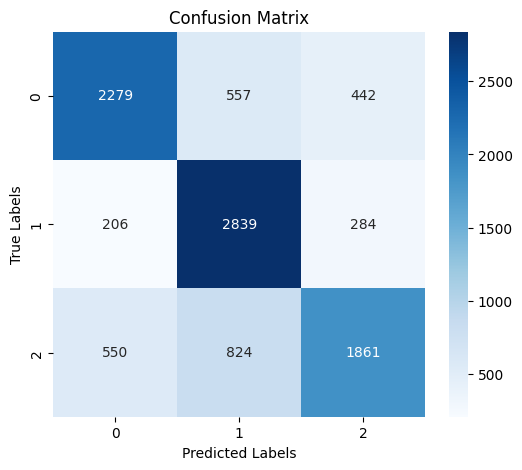

In [14]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define model architecture again (same as used in training)
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Adjust these based on your training config
input_dim = 768  # for BERT base embeddings
hidden_dim = 256
output_dim = 3   # number of classes in SNLI or your dataset

model = MLPClassifier(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load("mlp_classifier.pth"), strict=False)  # update filename if needed
model.eval()

# Load validation data
X_val = np.load('bert_val_embeddings.npy')
y_val = np.load('bert_val_labels_encoded.npy')

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Predict
with torch.no_grad():
    outputs = model(X_val_tensor)
    preds = torch.argmax(outputs, dim=1)

# Metrics
acc = accuracy_score(y_val, preds.numpy())
f1_macro = f1_score(y_val, preds.numpy(), average='macro')
f1_micro = f1_score(y_val, preds.numpy(), average='micro')
f1_weighted = f1_score(y_val, preds.numpy(), average='weighted')
cm = confusion_matrix(y_val, preds.numpy())

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
